# Analysis

This notebook contains routines for analyzing the output of keypoint-MoSeq.

```{note}
For the widgets below to work in a jupyter notebook, you must launch jupyter from a terminal in which the keypoint_moseq environment is active.
```

## Setup

We assume you have already have keypoint-MoSeq outputs that are organized as follows.
```
<project_dir>/               ** current working directory
└── <model_name>/             ** model directory
    ├── results.h5           ** model results
    └── grid_movies/         ** [Optional] grid movies folder
```
Use the code below to define your project directory and model name, and to check if the required jupyter extensions are enabled. If they are not, run the [installation commands](https://keypoint-moseq.readthedocs.io/en/latest/install.html#install-jupyter-extensions) and confirm that jupyter was launched from the `keypoint_moseq` environment, as mentioned in the note above. 


In [2]:
import keypoint_moseq as kpms

project_dir='path/to/project' # the full path to the project directory
model_name='model_name' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)

kpms.check_jupyter_extensions()

✅ The extension nbextensions_configurator is installed and enabled.
✅ The extension jupyter_bokeh is installed and enabled.
✅ The extension qgrid is installed and enabled.


## Assign Groups

The following cell invokes an interactive spreadsheet widget that can be used to annotate each recording with a group label. These labels are important later for performing group-wise comparisons. The annotations are saved to a to  `{project_dir}/index.yaml`.

- Select one or more rows, enter a group name and click `Set Group Name`
- Click any column header to sort rows alphabetically
- Click the filter icon in a column header to filter rows by name. 
- At any point, use `Update Index File` to save current group assignments.

In [3]:
index_file=kpms.interactive_group_setting(project_dir, model_name)

Button(description='Clear Output', style=ButtonStyle(), tooltip='Close Cell Output')

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Generate dataframes

Generate a pandas dataframe called `moseq_df` that contains syllable labels and kinematic information for each frame across all the recording sessions. 

In [ ]:
moseq_df = kpms.compute_moseq_df(project_dir, model_name, smooth_heading=True) 
moseq_df

In [5]:
import os
save_dir = os.path.join(project_dir, model_name) # directory to save the moseq_df dataframe
moseq_df.to_csv(os.path.join(save_dir, 'moseq_df.csv'), index=False)
print('Saved `moseq_df` dataframe to', save_dir)

Saved `moseq_df` dataframe to demo_project/2023_08_01-10_16_25


Next generate a dataframe called `stats_df` that contains summary statistics for each syllable in each recording session, such as its usage frequency and its distribution of kinematic parameters.

In [ ]:
stats_df = kpms.compute_stats_df(
    project_dir,
    model_name,
    moseq_df, 
    min_frequency=0.005,       # threshold frequency for including a syllable in the dataframe
    groupby=['group', 'name'], # column(s) to group the dataframe by
    fps=30)                    # frame rate of the video from which keypoints were inferred

stats_df

In [7]:
import os
save_dir = os.path.join(project_dir, model_name)
stats_df.to_csv(os.path.join(save_dir, 'stats_df'), index=False)
print('Saved `stats_df` dataframe to', save_dir)

Saved `stats_df` dataframe to demo_project/2023_08_01-10_16_25


##  Label syllables

Assign a name and short description to each syllable for downstream interpretation. These annotations are saved to `{project_dir}/{model_name}/syll_info.yaml`.

In [9]:
kpms.label_syllables(project_dir, model_name, moseq_df) 

Loading BokehJS ...

Button(description='Clear Output', style=ButtonStyle(), tooltip='Close Cell Output')

Dropdown(description='Syllable #:', options={'0 - mixed': {'desc': '', 'group_info': {}, 'label': 'mixed', 'mo…

Output()

## Compare between groups

Test for statistically significant differences between groups of recordings. The code below takes a syllable property (e.g. frequency or duration), plots its disribution for each syllable across for each group, and also tests whether the property differs significantly between groups. The results are summarized in a plot that is saved to `{project_dir}/{model_name}/analysis_figures`.

There are two options for setting the order of syllables along the x-axis. When `order='stat'`, syllables are sorted by the mean value of the statistic. When `order='diff'`, syllables are sorted by the magnitude of difference between two groups that are determined by the `ctrl_group` and `exp_group` keywords. Note `ctrl_group` and `exp_group` are not related to significance testing.

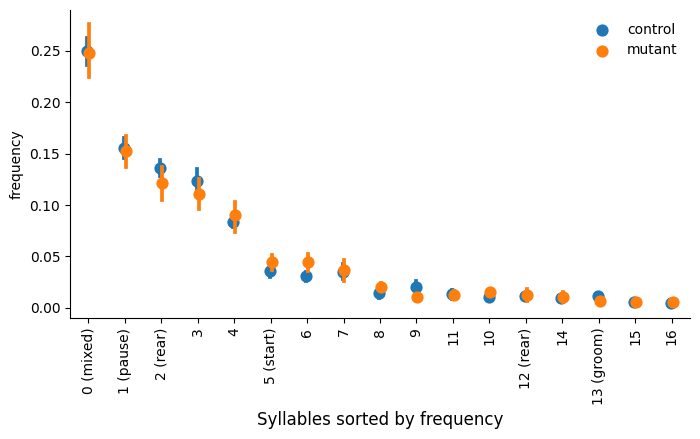

In [10]:
kpms.plot_syll_stats_with_sem(
    stats_df, project_dir, model_name,
    plot_sig=True,    # whether to mark statistical significance with a star
    thresh=0.05,      # significance threshold
    stat='frequency', # statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order='stat',     # order syllables by overall frequency ("stat") or degree of difference ("diff")
    ctrl_group='a',   # name of the control group for statistical testing
    exp_group='b',    # name of the experimental group for statistical testing
    figsize=(8, 4),   # figure size    
    groups=stats_df['group'].unique(), # groups to be plotted
);

### Transition matrices
Generate heatmaps showing the transition frequencies between syllables.

Group(s): control, mutant


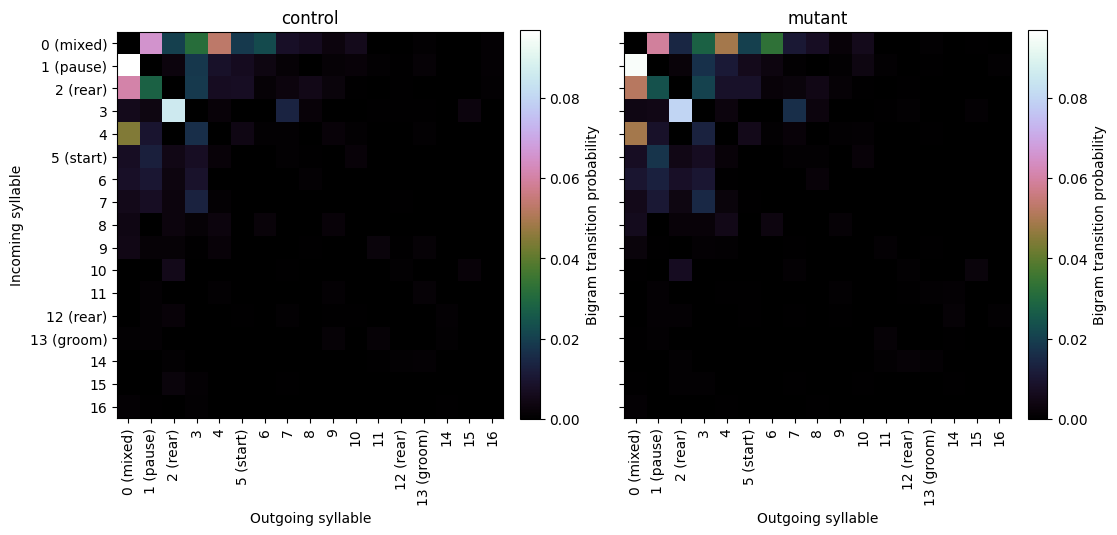

In [11]:
normalize='bigram' # normalization method ("bigram", "rows" or "columns")

trans_mats, usages, groups, syll_include=kpms.generate_transition_matrices(
    project_dir, model_name, normalize=normalize,
    min_frequency=0.005 # minimum syllable frequency to include
)    

kpms.visualize_transition_bigram(
    project_dir, model_name, groups, trans_mats, syll_include, normalize=normalize, 
    show_syllable_names=True # label syllables by index (False) or index and name (True)
)

### Syllable Transition Graph
Render transition rates in graph form, where nodes represent syllables and edges represent transitions between syllables, with edge showing transition rate for each pair of syllables (secifically the max of the two transition rates in each direction). The code below first generates a transition graph for each single group, and then generates a difference-graph for each pair of groups.

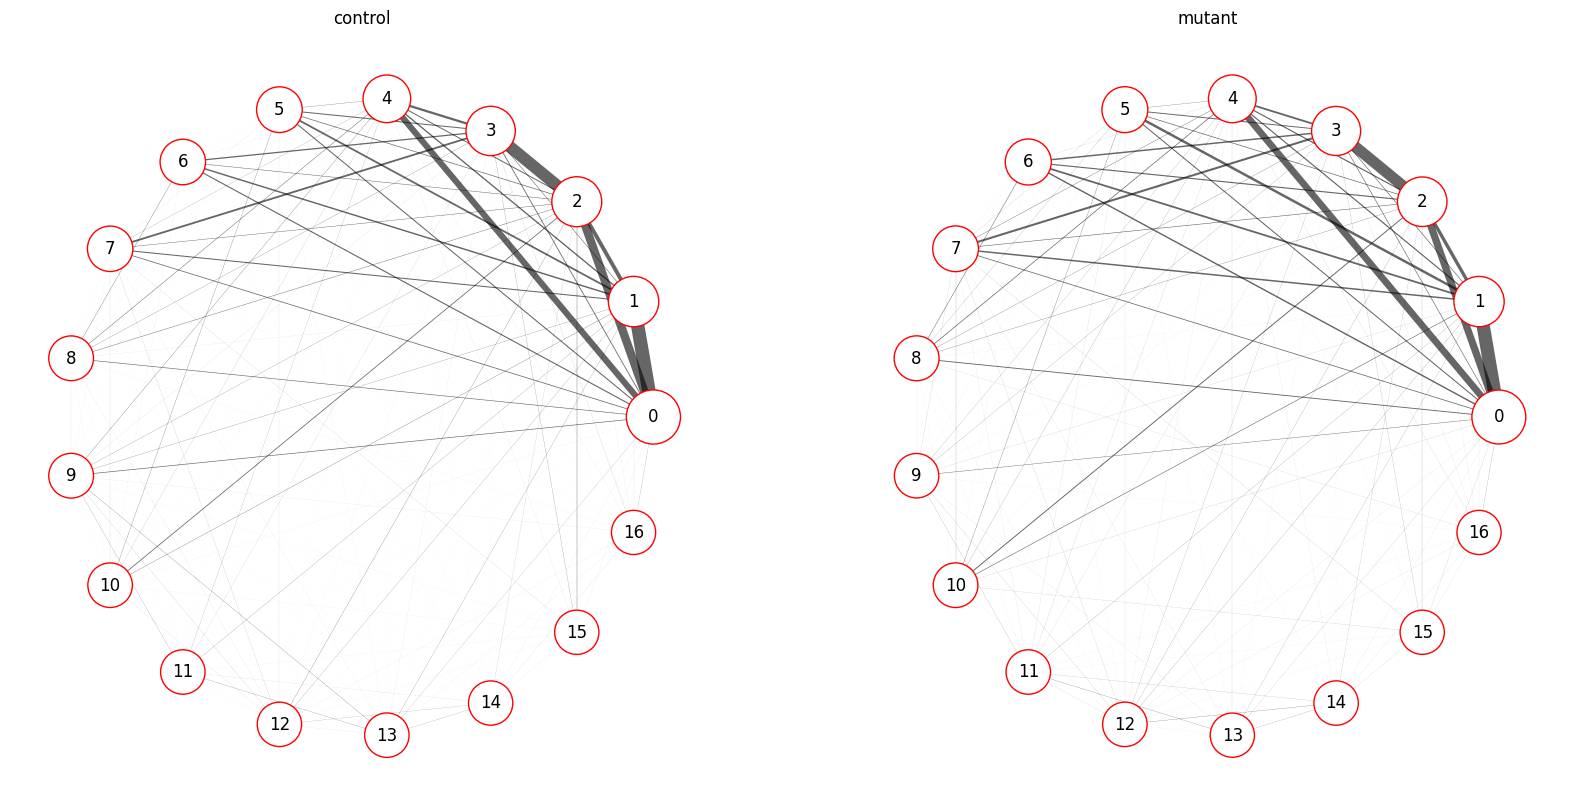

In [12]:
kpms.plot_transition_graph_group(
    project_dir, model_name, 
    groups, trans_mats, usages, syll_include, 
    layout='circular',        # transition graph layout ("circular" or "spring")
    show_syllable_names=False # label syllables by index (False) or index and name (True)
)

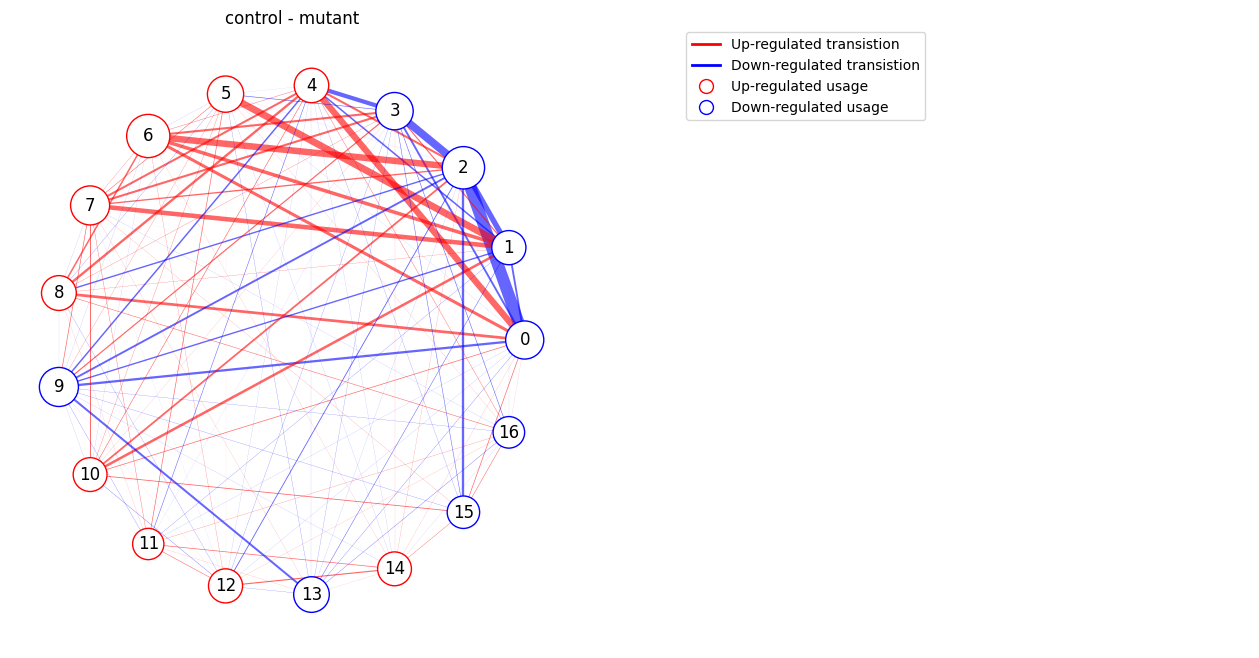

In [13]:
kpms.plot_transition_graph_difference(project_dir, model_name, 
                                      groups, trans_mats, usages, syll_include, 
                                      layout='circular') # transition graph layout ("circular" or "spring")